### Project - Predict heart attack based on phisiological and physical parameters fo the patient

### Action plan

1. Read, explore and clean all the data sets
2. See what all datasets have in common and how to relate them. 
3. Combine or merge relevant columns from datasets 1 and 3, to create a richer dataset. 
4. Plot main relations between variables to better understand the behaviour of the data.
5. Run Machine learning algorithms to train and test. The target is 0 or 1, depending on having or not a stroke.
6. Test all ML models and measure the error. Loop for different model parameters to get the optimal ones.
7. Get best model and run with data set stroke_predictorSet2.csv
8. Measure error. If not high enough, retrain ML models changing parameters.
9. Return best possible ML model to predict stroke with this data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### First data set analysis and cleaning

1. age
2. sex 1=male, 0=female
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl (100-130 normal, 130-160 above normal, more than 160 well above normal)
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [225]:
df_stroke = pd.read_csv('stroke_predictorSet.csv') 
df_stroke.dropna(inplace=True) #Remove Nan values
original_size = df_stroke.size

df_stroke[df_stroke.duplicated() == True] #Check for duplicates

df_stroke.drop_duplicates(inplace=True) #Remove duplicates and check size of the data frame

#Set appropriate names for the columns
columns = ['Age', 'Sex', 'ChestPain', 'SystolicPressure', 'Cholesterol', 'Diabetes', 'ecgStatus', 'MaxHeartBeat', 'InducedAngina',
           'STdepression','STslope', 'fluorVessels', 'Thalassemia', 'Target']
df_stroke.columns=columns

#Let´s select the columns common to the other datasets in order to compare them
df_stroke.drop(axis=1, columns=['ChestPain', 'ecgStatus', 'MaxHeartBeat', 'InducedAngina', 'STdepression', 'STslope', 'fluorVessels', 'Thalassemia'], inplace=True)

#Clasify Cholesterol column in three categories. (100-130 normal, 130-160 above normal, more than 160 well above normal)
df_stroke['Cholesterol']=pd.cut(df_stroke['Cholesterol'], bins=[0,130,160,1000],right=False, labels=[1,2,3])

#Duplicates were created after segmenting the columns
df_stroke[df_stroke.duplicated()==True].size 
#Remove duplicates
df_stroke.drop_duplicates(inplace=True) 
cleaned_size = df_stroke.size

print('Number of lost samples after cleaning stroke_predictorSet.csv: {:,.0f}%'.format(cleaned_size/original_size*100))
df_stroke.sample(5) #df_stroke clean and features ready for modeling


Number of lost samples after cleaning stroke_predictorSet.csv: 40%


,Age,Sex,SystolicPressure,Cholesterol,Diabetes,Target
97,52,1,108,3,1,1
224,54,1,110,3,0,0
229,64,1,125,3,0,0
287,57,1,154,3,0,0
163,38,1,138,3,0,1


### Second data set analysis and cleaning
1. Age | Objective Feature | age | int (days)
2. Height | Objective Feature | height | int (cm) |
3. Weight | Objective Feature | weight | float (kg) |
4. Gender | Objective Feature | gender | categorical code | 1 woman, 2 man
5. Systolic blood pressure | Examination Feature | ap_hi | int |
6. Diastolic blood pressure | Examination Feature | ap_lo | int |
7. Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | Subjective Feature | smoke | binary |
10. Alcohol intake | Subjective Feature | alco | binary |
11. Physical activity | Subjective Feature | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [224]:
df_stroke2 = pd.read_csv('stroke_predictorSet2.csv', sep=';')
df_stroke2.dropna(inplace=True)
original_size2 = df_stroke2.size

df_stroke2[df_stroke2.duplicated() == True] #Check for duplicates. There are no duplicates in this case

#Set appropiate column names for second dataset, according to the data in df_stroke
columns2 = ['Id','Age', 'Sex', 'Height', 'Weight','SystolicPressure', 'DiastolicPressure', 'Cholesterol', 'Diabetes', 'Smoker', 'Alcoholic',
           'ActiveSport','Target']
df_stroke2.columns=columns2

#Age was given in days, transform to years and round to closest integer
df_stroke2['Age']=(df_stroke2['Age']/365).astype(int) 

#Set female to value 0 like in the other datasets
df_stroke2.Sex[df_stroke2['Sex'] == 1] = 0
#set male to 1 like in the other datasets
df_stroke2.Sex[df_stroke2['Sex'] == 2] = 1 

#Let´s select the columns common to the other datasets in order to compare them
df_stroke2.drop(axis=1, columns=['Id', 'Height','Weight', 'DiastolicPressure', 'Smoker', 'Alcoholic', 'ActiveSport'], inplace=True)

#Caterogize diabetes column in only two catergories, 0 means normal and 1 means above normal or patient with diabetes (>100mg/dl blood sugar)
df_stroke2['Diabetes'] = pd.cut(df_stroke2['Diabetes'], bins=[1,2,3],labels=[0,1], right=False)

#Duplicates were created after column segmentation
df_stroke2[df_stroke2.duplicated()==True].size
#Remove duplicates
df_stroke2.drop_duplicates(inplace=True) 
cleaned_size2 = df_stroke2.size

print('Number of lost samples after cleaning stroke_predictorSet2.csv: {:,.0f}%'.format(cleaned_size2/original_size2*100))
df_stroke2.sample(5)

Number of lost samples after cleaning stroke_predictorSet2.csv: 5%


/home/carcrupe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/carcrupe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Age,Sex,SystolicPressure,Cholesterol,Diabetes,Target
66,52,1,130,1,0,0
14694,54,1,130,3,NaN,1
8865,63,0,110,3,1,1
38831,60,1,125,1,0,1
50773,48,0,140,2,1,0


### Third data set analysis and cleaning


In [227]:
df_stroke3 = pd.read_csv('stroke_predictoSet3.csv')
df_stroke3.dropna(inplace=True)
original_size3 = df_stroke3.size

#Check for duplicates. There are no duplicates in this case
df_stroke3[df_stroke3.duplicated() == True] 

columns3 = ['Sex', 'Age', 'Education', 'Smoker','CigarretesPerDay', 'BloodPressureMedicines', 'PreviousStroke', 'HyperSentitive', 'Diabetes', 'Cholesterol',
           'SystolicPressure','DiastolicPressure','BodyMassIndex','HeartRate','FastingBloodSugar', 'MoreThanTenYearDisease']
df_stroke3.columns=columns3

df_stroke3.drop(axis=1, columns= ['Education', 'Smoker','CigarretesPerDay', 'BloodPressureMedicines', 'PreviousStroke', 'HyperSentitive','DiastolicPressure','BodyMassIndex','HeartRate', 'FastingBloodSugar', 'MoreThanTenYearDisease'], inplace=True)

#Clasify Cholesterol column in three categories. (100-130 normal, 130-160 above normal, more than 160 well above normal)
df_stroke3['Cholesterol']=pd.cut(df_stroke3['Cholesterol'], bins=[0,130,160,1000],right=False, labels=[1,2,3])

#After removing columns, new duplicates were created. Remove them.
df_stroke3[df_stroke3.duplicated() == True].size
df_stroke3.drop_duplicates(inplace=True) 
cleaned_size3 = df_stroke3.size

print('Number of lost samples after cleaning stroke_predictoSet3.csv: {:,.0f}%'.format(cleaned_size3/original_size3*100))
df_stroke3.sample(5)


Number of lost samples after cleaning stroke_predictoSet3.csv: 23%


,Sex,Age,Diabetes,Cholesterol,SystolicPressure
489,0,51,0,3,98.0
849,0,36,0,3,102.0
3036,0,34,0,3,112.5
2974,0,61,0,3,174.5
1039,1,45,0,3,117.0


### Machine learning models

1. Test all the supervised models with df_stroke and df_stroke2
2. Select the best model for each dataset
3. Apply and predict stroke for df_stroke3

In [244]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor


# Create target object and call it y
y = df_stroke['Target']
# Create X
features = ['Age', 'Sex', 'SystolicPressure', 'Cholesterol', 'Diabetes']
X = df_stroke[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Specify Model
stroke_model = DecisionTreeRegressor(random_state=1)
# Fit Model
stroke_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = stroke_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))


Validation MAE: 0.396


In [230]:
#We define a function that returns the Mean Absolute error
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

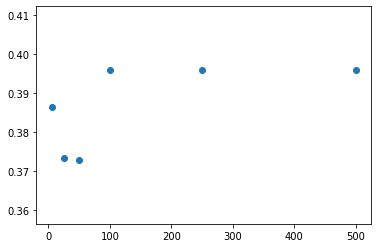

In [240]:
#The error in the first approach is quite high. Let us iterate to find the optimal tree parameters

candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
mae=[]
for x in candidate_max_leaf_nodes:
    mae.append(get_mae(x,train_X, val_X, train_y, val_y))

# Store the best value of max_leaf_nodes 
best_tree_size = candidate_max_leaf_nodes[mae.index(min(mae))]
plt.scatter(candidate_max_leaf_nodes,mae)

In [243]:
#Create optimal tree model
final_tree_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=0)

# fit the final model and calculate error
final_tree_model.fit(X, y)
val_predictions = final_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print("Validation MAE: {:,.3f}".format(val_mae))

Validation MAE: 0.243
